# Install Requirements

In [8]:
#!pip install nltk
#nltk.download()
#!pip install -U textblob
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('tagsets')
#!pip install -U pyLDAvis

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [5]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-07-26 02:44:30--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.78MB/s    in 1.6s    

2020-07-26 02:44:31 (9.78 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

# Import dependecies

In [9]:
import pandas as pd
import os
import requests 
from bs4 import BeautifulSoup as bs
from pprint import pprint
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from textblob import Word

import gensim 
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

from pyLDAvis import gensim as pgensim
import pyLDAvis.gensim
from gensim.models.phrases import Phrases, Phraser

# Text extraction

In [10]:
from google.colab import files
uploaded = files.upload()

Saving cases_name_year_url.csv to cases_name_year_url.csv


In [11]:
cases_df = pd.read_csv('cases_name_year_url.csv')
cases_df.head(2)

,name,year,url
0,MARBURY v. MADISON,1803,https://caselaw.findlaw.com/us-supreme-court/5...
1,GIBBONS v. OGDEN,1824,https://caselaw.findlaw.com/us-supreme-court/2...


In [12]:
#print length of the df
print('length:', len(cases_df))

length: 45


In [13]:
print('shape:', cases_df.shape)

shape: (45, 3)


In [14]:
# List of all the neccesary URLs
urls = list(cases_df['url'])

# Print length to see if it matches the DF
len(urls)

45

In [15]:
# Loop over urls to scrape the texts and append to our empty list

texts = []
list_url = []
list_text = []

counter = 1

for url in urls:
    
    response = requests.get(url)
    soup = bs(response.text,'html.parser')
    results = soup.find_all("div", class_="caselawcontent searchable-content")[0].get_text() 
    list_url.append(url)
    list_text.append(results)
    print(f"Scraped Case: {counter} {url}")
    counter = counter + 1

Scraped Case: 1 https://caselaw.findlaw.com/us-supreme-court/5/137.html
Scraped Case: 2 https://caselaw.findlaw.com/us-supreme-court/22/1.html
Scraped Case: 3 https://caselaw.findlaw.com/us-supreme-court/31/515.html
Scraped Case: 4 https://caselaw.findlaw.com/us-supreme-court/60/393.html
Scraped Case: 5 https://caselaw.findlaw.com/us-supreme-court/94/113.html
Scraped Case: 6 https://caselaw.findlaw.com/us-supreme-court/198/45.html
Scraped Case: 7 https://caselaw.findlaw.com/us-supreme-court/250/616.html
Scraped Case: 8 https://caselaw.findlaw.com/us-supreme-court/262/447.html
Scraped Case: 9 https://caselaw.findlaw.com/us-supreme-court/347/483.html
Scraped Case: 10 https://caselaw.findlaw.com/us-supreme-court/274/200.html
Scraped Case: 11 https://caselaw.findlaw.com/us-supreme-court/36/420.html
Scraped Case: 12 https://caselaw.findlaw.com/us-supreme-court/283/697.html
Scraped Case: 13 https://caselaw.findlaw.com/us-supreme-court/317/111.html
Scraped Case: 14 https://caselaw.findlaw.com

In [16]:
# Create a new df of the scraped text

scraped_text_url = {'url':list_url, 'text':list_text}
scraped_text_url = pd.DataFrame(scraped_text_url)
scraped_text_url.head(2)

,url,text
0,https://caselaw.findlaw.com/us-supreme-court/5...,\n\nUnited States Supreme Court\nMARBURY v. MA...
1,https://caselaw.findlaw.com/us-supreme-court/2...,\n\nUnited States Supreme Court\nGIBBONS v. OG...


In [17]:
# Merge the two dataframes together

cases_df=cases_df.merge(scraped_text_url, on='url')
cases_df.head(2)

,name,year,url,text
0,MARBURY v. MADISON,1803,https://caselaw.findlaw.com/us-supreme-court/5...,\n\nUnited States Supreme Court\nMARBURY v. MA...
1,GIBBONS v. OGDEN,1824,https://caselaw.findlaw.com/us-supreme-court/2...,\n\nUnited States Supreme Court\nGIBBONS v. OG...


In [18]:
cases_df.to_csv("final_data.csv")

# Text Preprocessing

In [19]:
# Remove \n (whitelines)
cases_df = cases_df.replace('\n',' ', regex=True)

# Lowercase
cases_df['text'] = cases_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove numbers
cases_df['text'] = cases_df['text'].str.replace('\d+', '')
cases_df['text'].head()

<input>:8: DeprecationWarning: invalid escape sequence \d
<input>:8: DeprecationWarning: invalid escape sequence \d
<input>:8: DeprecationWarning: invalid escape sequence \d
<input>:8: DeprecationWarning: invalid escape sequence \d
<input>:8: DeprecationWarning: invalid escape sequence \d
<input>:8: DeprecationWarning: invalid escape sequence \d
<ipython-input-19-59f39f24ab7a>:8: DeprecationWarning: invalid escape sequence \d
  cases_df['text'] = cases_df['text'].str.replace('\d+', '')


0    united states supreme court marbury v. madison...
1    united states supreme court gibbons v. ogden()...
2    united states supreme court worcester v. state...
3    united states supreme court dred scott v. sand...
4    united states supreme court munn v. state of i...
Name: text, dtype: object

In [20]:
cases_df = cases_df.replace({'united states supreme court': '','footnotes': '','footnote': '','et al': '','ii': '','ii': '','iii': '','www': '','jiii': '','supra': '','may': '','rule': '','case': '','police': '','confession': '','make': '','statement': '','give': ''}, regex=True)


# Stopwords removal 

In [24]:
stop = stopwords.words('english')

cases_df['text'] = cases_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

cases_df['text'][0][:400]

'marbury v. madison() argued: decided: february , december term , william marbury, dennis ramsay, robert townsend hooe, william harper, counsel [ u.s. , ] severally moved court james madison, secretary state united states, show cause mandamus issue commanding cause delivered respectively several commissions justices peace district columbia. motion supported affidavits following facts: notice motion'

# Sentence tokenization

In [25]:
sent_tokens = cases_df['text']
sent_tokens = sent_tokens.apply(sent_tokenize)
sent_tokens.head()

0    [marbury v. madison() argued: decided: februar...
1    [gibbons v. ogden() no., argued: decided: marc...
2    [worcester v. state ga.() no., argued: decided...
3    [dred scott v. sandford() no., argued: decided...
4    [munn v. state illinois() argued: decided: oct...
Name: text, dtype: object

In [26]:
names = cases_df['name']
names.head(2)

0    MARBURY v. MADISON
1      GIBBONS v. OGDEN
Name: name, dtype: object

In [27]:
# Create a dataframe for sentence tokens to do more text processing below

sent_tokens_df = pd.DataFrame(sent_tokens)
sent_tokens_df.rename(columns={'text': 'sent_tokens'}, inplace= True)
sent_tokens_df.head()

,sent_tokens
0,[marbury v. madison() argued: decided: februar...
1,"[gibbons v. ogden() no., argued: decided: marc..."
2,"[worcester v. state ga.() no., argued: decided..."
3,"[dred scott v. sandford() no., argued: decided..."
4,[munn v. state illinois() argued: decided: oct...


In [28]:
# Join sentence tokens with case names

big_df = sent_tokens_df.join(names)
big_df.head()

,sent_tokens,name
0,[marbury v. madison() argued: decided: februar...,MARBURY v. MADISON
1,"[gibbons v. ogden() no., argued: decided: marc...",GIBBONS v. OGDEN
2,"[worcester v. state ga.() no., argued: decided...",WORCESTER v. STATE OF GA.
3,"[dred scott v. sandford() no., argued: decided...",DRED SCOTT v. SANDFORD
4,[munn v. state illinois() argued: decided: oct...,MUNN v. STATE OF ILLINOIS


# Dataframe for Unique Cases

In [29]:
# Manipulate the dataframe to get topics for only one case
unique_case = big_df.explode('sent_tokens')#.set_index('names').
unique_case.head()

,sent_tokens,name
0,marbury v. madison() argued: decided: february...,MARBURY v. MADISON
0,motion supported affidavits following facts: n...,MARBURY v. MADISON
0,"duly served-- [ u.s. , ] mr. jacob wagner mr. ...",MARBURY v. MADISON
0,"court ordered witnesses sworn, answers taken w...",MARBURY v. MADISON
0,"mr. lincoln, acting secretary state, circumsta...",MARBURY v. MADISON


In [30]:
# Unstack dataframe 
unstacked_df = unique_case.set_index(['name',unique_case.groupby('name').cumcount()])['sent_tokens'].unstack().T

In [31]:
unstacked_df.head(3)

name,ABRAMS v. U S,ATLANTA MOTEL v. UNITED STATES,BRANDENBURG v. OHIO,BROWN v. BOARD OF EDUCATION,BUCK v. BELL(1927),BUCKLEY v. VALEO,CHARLES RIVER BRIDGE v. WARREN BRIDGE,CHEVRON US A. v. NATURAL RES. DEF. COUNCIL,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,COM. OF MASSACHUSETTS v. MELLON,"CRUZAN v. DIRECTOR, MDH",DISTRICT OF COLUMBIA ET AL. v. HELLER,DRED SCOTT v. SANDFORD,ENGEL v. VITALE,FIRST NATIONAL BANK OF BOSTON v. BELLOTTI,GEORGIA v. RANDOLPH,GIBBONS v. OGDEN,GIDEON v. WAINWRIGHT,LAWRENCE V. TEXAS,LOCHNER v. PEOPLE OF STATE OF NEW YORK,LOVING v. VIRGINIA,MAPP v. OHIO,MARBURY v. MADISON,MASSACHUSETTS ET AL. v. ENVIRONMENTAL PROTECTION AGENCY ET AL.,MICHAEL H. v. GERALD D.,MIRANDA v. ARIZONA,MUNN v. STATE OF ILLINOIS,"NATIONAL FEDERATION OF INDEPENDENT BUSINESS ET AL. v. SEBELIUS, SECRETARY OF HEALTH AND HUMAN SERVICES, ET AL.",NEAR v.MINNESOTA,NEW YORK TIMES CO. v. SULLIVAN,"OBERGEFELL ET AL. v. HODGES, DIRECTOR, OHIO DEPARTMENT OF HEALTH, ET AL.",OCONNOR v. DONALDSON,PHILLIPS v. MARTIN MARIETTA CORP.,PLESSY v. FERGUSON,REYNOLDS v. SIMS,ROE v. WADE,SAN ANTONIO SCHOOL DISTRICT v. RODRIGUEZ,STRICKLAND v. WASHINGTON,TERRY v. OHIO,TEXAS v. JOHNSON,UNITED STATES v. NIXON,UNIVERSITY OF CALIFORNIA REGENTS v. BAKKE,WICKARD v. FILBURN,WISCONSIN v. YODER,WORCESTER v. STATE OF GA.
0,abrams v. u s() no.,atlanta motel v. united states() no.,brandenburg v. ohio() no.,brown v. board education() no.,buck v. bell() no.,buckley v. valeo() no.,proprietors charles river bridge v. proprietor...,chevron u.s. a. v. natural res.,citizens united v. federal election commission...,com.,"cruzan v. director, mdh() no.",district columbia .,dred scott v. sandford() no.,engel v. vitale() no.,first national bank boston v. bellotti() no.,georgia v. randolph() no.,gibbons v. ogden() no.,gideon v. wainwright() no.,lawrence .,lochner v. people state new york() no.,loving v. virginia() no.,mapp v. ohio() no.,marbury v. madison() argued: decided: february...,massachusetts .,michael h. v. gerald d.() no.,miranda v. arizona() no.,munn v. state illinois() argued: decided: octo...,national federation independent business .,near v. state minnesota ex rel.,new york times co. v. sullivan() no.,obergefell .,o'connor v. donaldson() no.,phillips v. martin marietta corp.() no.,plessy v. ferguson() no.,reynolds v. sims() no.,roe v. wade() no.,san antonio school district v. rodriguez() no.,strickland v. washington() no.,terry v. ohio() no.,texas v. johnson() no.,united states v. nixon() no.,university california regents v. bakke() no.,wickard v. filburn() no.,wisconsin v. yoder() no.,worcester v. state ga.() no.
1,"argued: decided: november , mr. harry weinberg...","argued: october , decided: december , appellan...","argued: february , decided: june , appellant, ...","argued: december , decided: , segregation whit...","argued: april , decided: , [ u.s. , ] mr. i. p...","- argued: november , decided: january , [ * ] ...",plaintiffs error corporation created act legis...,def.,"- argued: march , decided: january , amended §...",massachusetts v. mellon() argued: decided: jun...,"- argued: december , decided: june , petitione...",v. heller() no.,"argued: decided: december , [ u.s. , ] brought...","argued: april , decided: june , prohibition fi...","- argued: november , decided: april , appellan...","- argued: november , decided: march , responde...","argued: decided: march , acts legislature stat...","argued: january , decided: march , charged flo...",v. texas() no.,"argued: decided: april , general right contrac...","argued: april , decided: june , virginia's sta...","argued: march , decided: june , evidence obtai...",motion supported affidavits following facts: n...,v. environmental protection agency .,"- argued: october , decided: june , , appellan...","argued: decided: june , [ * ] together no.","constitution illinois, adopted , contains foll...","v. sebelius, secretary health human services, .",olson() no.,"argued: january , decided: march , [ * ] toget...","v. hodge

In [32]:
# Select a case
case1 = unstacked_df['MIRANDA v. ARIZONA']
case1 = pd.DataFrame(case1).dropna()
case1.head() 

,MIRANDA v. ARIZONA
0,miranda v. arizona() no.
1,"argued: decided: june , [ * ] together no."
2,", vignera v. new york, certiorari court appeal..."
3,", westover v. united states, certiorari united..."
4,", california v. stewart, certiorari supreme co..."


# Preprocessing

In [33]:
case1['MIRANDA v. ARIZONA']

0                                miranda v. arizona() no.
1              argued: decided: june , [ * ] together no.
2       , vignera v. new york, certiorari court appeal...
3       , westover v. united states, certiorari united...
4       , california v. stewart, certiorari supreme co...
                              ...                        
1725           , ,, .% ,, serious known offenses cleared.
1726       clearance rate ranged .% homicides .% larceny.
1727                  fbi, uniform crime reports - , -, .
1728    would replace interrogation investigatorial to...
1729                                           [ u.s. , ]
Name: MIRANDA v. ARIZONA, Length: 1730, dtype: object

In [34]:
# Remove punctuation
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].str.replace('[^\w\s]','')

# Remove words if length less than 1
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Lemmatize
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].apply(lambda x: " ".join([Word(word).lemmatize('v') for word in x.split()]))

<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: DeprecationWarning: invalid escape sequence \w
<input>:2: Dep

In [36]:
# Word tokenization for case 1
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].apply(nltk.word_tokenize)

In [37]:
# Remove empty lists

case1 = case1[case1.astype(str)['MIRANDA v. ARIZONA'] != '[]']

In [38]:
# Convert string to list values
data = case1.values.tolist()

In [39]:
case1 = case1['MIRANDA v. ARIZONA']
case1

0                                      [miranda, arizona]
1                         [argue, decide, june, together]
2       [vignera, new, york, certiorari, court, appeal...
3       [westover, unite, state, certiorari, unite, st...
4       [california, stewart, certiorari, supreme, cou...
                              ...                        
1724    [perhaps, equal, significance, number, instanc...
1725                     [serious, know, offenses, clear]
1726         [clearance, rate, range, homicides, larceny]
1727                        [fbi, uniform, crime, report]
1728    [would, replace, interrogation, investigatoria...
Name: MIRANDA v. ARIZONA, Length: 1467, dtype: object

In [40]:
# Create a dataframe for MIRANDA v. ARIZONA
case1_df = pd.DataFrame(case1)
case1_df.head()

,MIRANDA v. ARIZONA
0,"[miranda, arizona]"
1,"[argue, decide, june, together]"
2,"[vignera, new, york, certiorari, court, appeal..."
3,"[westover, unite, state, certiorari, unite, st..."
4,"[california, stewart, certiorari, supreme, cou..."


In [41]:
case1_df.head(2)

,MIRANDA v. ARIZONA
0,"[miranda, arizona]"
1,"[argue, decide, june, together]"


# Topic Modeling for 'MIRANDA v. ARIZONA'

In [42]:
##### Create Bigrams for Miranda v. Arizona

In [43]:
# Build the bigram and trigram models

bigram = Phrases(case1, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[case1], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [44]:
# See trigram example
print(trigram_mod[bigram_mod[case1[0]]])

['miranda', 'arizona']


In [45]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [46]:
 # Form Bigrams
data_words_bigrams = make_bigrams(case1)

# LDA Mallet Modeling with Bigrams for Miranda v. Arizona








In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [48]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

# Show Topics

pprint(ldamallet.show_topics(formatted=True))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[(0,
  '0.083*"state" + 0.069*"court" + 0.035*"unite" + 0.020*"federal" + '
  '0.016*"justice" + 0.013*"general" + 0.012*"california" + 0.011*"new_york" + '
  '0.010*"find" + 0.009*"westover"'),
 (1,
  '0.047*"question" + 0.031*"evidence" + 0.027*"individual" + 0.026*"attorney" '
  '+ 0.024*"person" + 0.018*"officer" + 0.018*"suspect" + 0.013*"subject" + '
  '0.013*"custody" + 0.012*"point"'),
 (2,
  '0.073*"interrogation" + 0.047*"counsel" + 0.042*"privilege" + 0.035*"warn" '
  '+ 0.025*"defendant" + 0.023*"constitutional" + 0.021*"fifth_amendment" + '
  '0.020*"present" + 0.019*"accuse" + 0.017*"obtain"'),
 (3,
  '0.024*"law" + 0.022*"time" + 0.022*"arrest" + 0.017*"crime" + 0.017*"fact" '
  '+ 0.016*"law_enforcement" + 0.015*"practice" + 0.015*"criminal" + '
  '0.013*"rev" + 0.013*"fbi"'),
 (4,
  '0.041*"court" + 0.025*"make" + 0.020*"trial" + 0.017*"today" + '
  '0.015*"criminal" + 0.015*"decision" + 0.015*"waiver" + 0.013*"prior" + '
  '0.012*"opinion" + 0.012*"constitution"')]

C

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [50]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


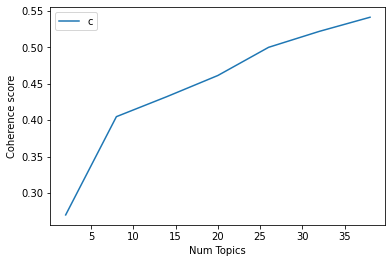

In [51]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
mlist = []
cvlist = []

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    mlist.append(m)
    cvlist.append(cv)
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
best_coherence = pd.DataFrame({"m":mlist,"cv":cvlist})
best_index = best_coherence.idxmax()[0]

Num Topics = 2  has Coherence Value of 0.2699
Num Topics = 8  has Coherence Value of 0.4047
Num Topics = 14  has Coherence Value of 0.4324
Num Topics = 20  has Coherence Value of 0.4613
Num Topics = 26  has Coherence Value of 0.4999
Num Topics = 32  has Coherence Value of 0.5218
Num Topics = 38  has Coherence Value of 0.5412


In [54]:
# Select the model and print the topics
optimal_model = model_list[best_index]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(26,
  '0.095*"today" + 0.066*"find" + 0.052*"circumstances" + 0.040*"escobedo" + '
  '0.037*"term" + 0.037*"guilty" + 0.034*"law" + 0.034*"involuntary" + '
  '0.032*"simply" + 0.032*"bring"'),
 (18,
  '0.124*"practice" + 0.093*"rev" + 0.084*"arrest" + 0.043*"investigation" + '
  '0.043*"detention" + 0.043*"charge" + 0.022*"allege" + '
  '0.022*"civil_liberties" + 0.022*"add" + 0.019*"secret"'),
 (5,
  '0.143*"law" + 0.098*"law_enforcement" + 0.065*"report" + 0.028*"commission" '
  '+ 0.028*"study" + 0.025*"country" + 0.020*"third_degree" + 0.020*"national" '
  '+ 0.020*"undertake" + 0.020*"agencies"'),
 (36,
  '0.090*"effective" + 0.058*"safeguard" + 0.049*"exercise" + 0.049*"follow" + '
  '0.043*"persons" + 0.040*"employ" + 0.035*"silence" + 0.035*"fully" + '
  '0.032*"show" + 0.032*"opportunity"'),
 (1,
  '0.225*"accuse" + 0.110*"require" + 0.101*"waiver" + 0.035*"exclude" + '
  '0.026*"admissions" + 0.026*"testimony" + 0.026*"proof" + 0.023*"truth" + '
  '0.023*"assume" + 0.014*"r

In [55]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print(f'Coherence Score for Optimal Model: {coherence_ldamallet}')

Coherence Score for Optimal Model: 0.5412430931055768


# More text preprocessing for dataframe that includes all landmark cases

In [56]:
big_df.head()

,sent_tokens,name
0,[marbury v. madison() argued: decided: februar...,MARBURY v. MADISON
1,"[gibbons v. ogden() no., argued: decided: marc...",GIBBONS v. OGDEN
2,"[worcester v. state ga.() no., argued: decided...",WORCESTER v. STATE OF GA.
3,"[dred scott v. sandford() no., argued: decided...",DRED SCOTT v. SANDFORD
4,[munn v. state illinois() argued: decided: oct...,MUNN v. STATE OF ILLINOIS


In [57]:
# Remove brackets from list
big_df['sent_tokens'] = big_df['sent_tokens'].apply(lambda x: ",".join(x) if isinstance(x, list) else x)

# Remove punctuation
big_df['sent_tokens']  = big_df['sent_tokens'].str.replace('[^\w\s]','')

# Remove words if length less than 1
big_df['sent_tokens']  = big_df['sent_tokens'] .apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
big_df['sent_tokens'].head()
big_df.head()

<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:5: Dep

,sent_tokens,name
0,marbury madison argued decided february decemb...,MARBURY v. MADISON
1,gibbons ogden noargued decided march acts legi...,GIBBONS v. OGDEN
2,worcester state ga noargued decided january us...,WORCESTER v. STATE OF GA.
3,dred scott sandford noargued decided december ...,DRED SCOTT v. SANDFORD
4,munn state illinois argued decided october mun...,MUNN v. STATE OF ILLINOIS


## Lemmatization

In [58]:
big_df['sent_tokens']  = big_df['sent_tokens'] .apply(lambda x: " ".join([Word(word).lemmatize('v') for word in x.split()]))

big_df.head()

,sent_tokens,name
0,marbury madison argue decide february december...,MARBURY v. MADISON
1,gibbons ogden noargued decide march act legisl...,GIBBONS v. OGDEN
2,worcester state ga noargued decide january us ...,WORCESTER v. STATE OF GA.
3,dred scott sandford noargued decide december u...,DRED SCOTT v. SANDFORD
4,munn state illinois argue decide october munn ...,MUNN v. STATE OF ILLINOIS


In [59]:
big_df['sent_tokens'][0][:400]

'marbury madison argue decide february december term william marbury dennis ramsay robert townsend hooe william harper counsel us severally move court jam madison secretary state unite state show cause mandamus issue command cause deliver respectively several commission justices peace district columbiamotion support affidavits follow facts notice motion mr madison mr adams late president unite stat'

In [60]:
# Set variable for sentence tokens to do word tokenization below
sentence_tokens = big_df['sent_tokens']
sentence_tokens.head()

0    marbury madison argue decide february december...
1    gibbons ogden noargued decide march act legisl...
2    worcester state ga noargued decide january us ...
3    dred scott sandford noargued decide december u...
4    munn state illinois argue decide october munn ...
Name: sent_tokens, dtype: object

In [61]:
names = cases_df['name']

In [62]:
sent_tokens_df =pd.DataFrame(sentence_tokens)
sent_tokens_df.head()

,sent_tokens
0,marbury madison argue decide february december...
1,gibbons ogden noargued decide march act legisl...
2,worcester state ga noargued decide january us ...
3,dred scott sandford noargued decide december u...
4,munn state illinois argue decide october munn ...


#  Word tokenization



In [63]:
text_tokens = sentence_tokens.apply(word_tokenize)
text_tokens.head()

0    [marbury, madison, argue, decide, february, de...
1    [gibbons, ogden, noargued, decide, march, act,...
2    [worcester, state, ga, noargued, decide, janua...
3    [dred, scott, sandford, noargued, decide, dece...
4    [munn, state, illinois, argue, decide, october...
Name: sent_tokens, dtype: object

In [64]:
text_tokens_df = pd.DataFrame(text_tokens)
text_tokens_df = text_tokens_df.rename(columns={'sent_tokens': 'word_tokens'})
text_tokens_df.head()

,word_tokens
0,"[marbury, madison, argue, decide, february, de..."
1,"[gibbons, ogden, noargued, decide, march, act,..."
2,"[worcester, state, ga, noargued, decide, janua..."
3,"[dred, scott, sandford, noargued, decide, dece..."
4,"[munn, state, illinois, argue, decide, october..."


In [65]:
# List of tokens for every case

listy = []
for i in range(len(text_tokens_df['word_tokens'])):
    listy.append(text_tokens_df['word_tokens'][i])

### Part-Of-Speech Tagging

In [68]:
# Get POS tags with NLTK
pos_tag = text_tokens.apply(nltk.pos_tag)
pos_tag.head()

0    [(marbury, NN), (madison, NN), (argue, NN), (d...
1    [(gibbons, NNS), (ogden, VBP), (noargued, VBN)...
2    [(worcester, NN), (state, NN), (ga, NN), (noar...
3    [(dred, VBN), (scott, NN), (sandford, NN), (no...
4    [(munn, NN), (state, NN), (illinois, NN), (arg...
Name: sent_tokens, dtype: object

In [72]:
# Find out the meaning of specific tags

nltk.help.upenn_tagset("JJ")
nltk.help.upenn_tagset("NN")

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


In [73]:
# Convert series to dataframe
pos_tag_df = pd.Series(pos_tag,
               name="POS_tags")
pos_tag_df.to_frame().head()

,POS_tags
0,"[(marbury, NN), (madison, NN), (argue, NN), (d..."
1,"[(gibbons, NNS), (ogden, VBP), (noargued, VBN)..."
2,"[(worcester, NN), (state, NN), (ga, NN), (noar..."
3,"[(dred, VBN), (scott, NN), (sandford, NN), (no..."
4,"[(munn, NN), (state, NN), (illinois, NN), (arg..."


In [74]:
# Merge the two dataframes together

text_and_tokens = pd.concat([cases_df, text_tokens_df], axis=1)
text_and_tokens.head()

,name,year,url,text,word_tokens
0,MARBURY v. MADISON,1803,https://law.findlaw.com/us-supreme-court/5/137...,marbury v. madison() argued: decided: february...,"[marbury, madison, argue, decide, february, de..."
1,GIBBONS v. OGDEN,1824,https://law.findlaw.com/us-supreme-court/22/1....,gibbons v. ogden() no. argued: decided: march ...,"[gibbons, ogden, noargued, decide, march, act,..."
2,WORCESTER v. STATE OF GA.,1832,https://law.findlaw.com/us-supreme-court/31/51...,worcester v. state ga.() no. argued: decided: ...,"[worcester, state, ga, noargued, decide, janua..."
3,DRED SCOTT v. SANDFORD,1856,https://law.findlaw.com/us-supreme-court/60/39...,dred scott v. sandford() no. argued: decided: ...,"[dred, scott, sandford, noargued, decide, dece..."
4,MUNN v. STATE OF ILLINOIS,1876,https://law.findlaw.com/us-supreme-court/94/11...,munn v. state illinois() argued: decided: octo...,"[munn, state, illinois, argue, decide, october..."


# Exploring the Data

In [75]:
# TF-IDF

frequency_dist = text_tokens.apply(nltk.FreqDist)
frequency_dist.head(10)

0    {'marbury': 8, 'madison': 6, 'argue': 3, 'deci...
1    {'gibbons': 8, 'ogden': 9, 'noargued': 1, 'dec...
2    {'worcester': 17, 'state': 454, 'ga': 1, 'noar...
3    {'dred': 25, 'scott': 50, 'sandford': 11, 'noa...
4    {'munn': 6, 'state': 112, 'illinois': 17, 'arg...
5    {'lochner': 1, 'people': 15, 'state': 91, 'new...
6    {'abrams': 5, 'noargued': 1, 'decide': 1, 'nov...
7    {'commassachusetts': 1, 'mellon': 2, 'argue': ...
8    {'brown': 2, 'board': 8, 'education': 26, 'noa...
9    {'buck': 4, 'bell': 1, 'noargued': 1, 'april':...
Name: sent_tokens, dtype: object

In [76]:
# Convert list of tokens for MIRANDA v. ARIZONA to strings

case1_df['liststringCase1'] = [','.join(map(str, l)) for l in case1_df['MIRANDA v. ARIZONA']]
case1_df['liststringCase1']

0                                         miranda,arizona
1                              argue,decide,june,together
2       vignera,new,york,certiorari,court,appeal,new,york
3       westover,unite,state,certiorari,unite,state,co...
4       california,stewart,certiorari,supreme,court,ca...
                              ...                        
1724    perhaps,equal,significance,number,instance,kno...
1725                          serious,know,offenses,clear
1726               clearance,rate,range,homicides,larceny
1727                             fbi,uniform,crime,report
1728    would,replace,interrogation,investigatorial,to...
Name: liststringCase1, Length: 1467, dtype: object

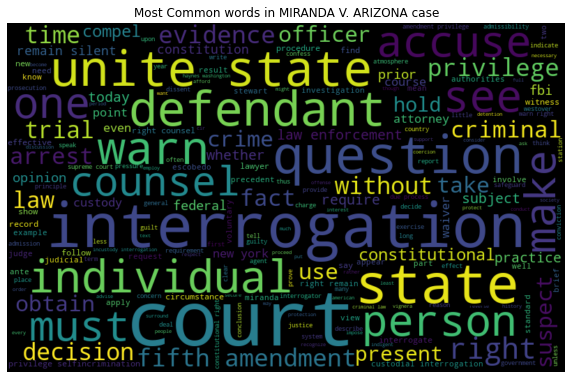

In [77]:
# Wordcloud

all_words = ' '.join([text for text in case1_df['liststringCase1']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in MIRANDA V. ARIZONA case")
plt.show()

# Creating Bigram and Trigram Models for all cases

In [78]:
# Build the bigram and trigram models

bigram = Phrases(listy, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[listy], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[listy[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['marbury_madison', 'argue', 'decide', 'february', 'december', 'term', 'william', 'marbury', 'dennis', 'ramsay', 'robert', 'townsend', 'hooe', 'william', 'harper', 'counsel', 'us', 'severally', 'move', 'court', 'jam_madison', 'secretary', 'state', 'unite', 'state', 'show', 'cause', 'mandamus', 'issue', 'command', 'cause', 'deliver', 'respectively', 'several', 'commission', 'justices', 'peace', 'district', 'columbiamotion', 'support', 'affidavits', 'follow', 'facts', 'notice', 'motion', 'mr_madison', 'mr', 'adams', 'late', 'president', 'unite', 'state', 'nominate', 'applicants', 'senate', 'advice_consent', 'appoint', 'justices', 'peace', 'district_columbia', 'senate', 'advise', 'consent', 'appointments', 'commission', 'due', 'form', 'sign', 'say', 'president', 'appoint', 'justices', 'seal', 'unite', 'state', 'due', 'form', 'affix', 'say', 'commission', 'secretary', 'state', 'applicants', 'request', 'mr_madison', 'deliver', 'say', 'commission', 'comply', 'request', 'say', 'commission', '

In [79]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [80]:
# Form Bigrams
data_words_bigrams = make_bigrams(listy)
data_words_bigrams 

[['marbury_madison',
  'argue',
  'decide',
  'february',
  'december',
  'term',
  'william',
  'marbury',
  'dennis',
  'ramsay',
  'robert',
  'townsend',
  'hooe',
  'william',
  'harper',
  'counsel',
  'us',
  'severally',
  'move',
  'court',
  'jam_madison',
  'secretary',
  'state',
  'unite',
  'state',
  'show',
  'cause',
  'mandamus',
  'issue',
  'command',
  'cause',
  'deliver',
  'respectively',
  'several',
  'commission',
  'justices',
  'peace',
  'district',
  'columbiamotion',
  'support',
  'affidavits',
  'follow',
  'facts',
  'notice',
  'motion',
  'mr_madison',
  'mr',
  'adams',
  'late',
  'president',
  'unite',
  'state',
  'nominate',
  'applicants',
  'senate',
  'advice_consent',
  'appoint',
  'justices',
  'peace',
  'district_columbia',
  'senate',
  'advise',
  'consent',
  'appointments',
  'commission',
  'due',
  'form',
  'sign',
  'say',
  'president',
  'appoint',
  'justices',
  'seal',
  'unite',
  'state',
  'due',
  'form',
  'affix',
  

# LDA Modeling for all cases

In [82]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 4), (11, 3), (12, 1), (13, 1), (14, 5), (15, 1), (16, 1), (17, 1), (18, 1), (19, 72), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 7), (35, 1), (36, 1), (37, 1), (38, 6), (39, 4), (40, 1), (41, 15), (42, 5), (43, 1), (44, 1), (45, 1), (46, 2), (47, 2), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 4), (54, 3), (55, 3), (56, 1), (57, 2), (58, 1), (59, 1), (60, 3), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 4), (73, 1), (74, 1), (75, 1), (76, 3), (77, 1), (78, 5), (79, 13), (80, 1), (81, 2), (82, 6), (83, 4), (84, 3), (85, 1), (86, 10), (87, 1), (88, 26), (89, 1), (90, 1), (91, 40), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 3), (99, 1), (100, 1), (101, 3), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 2), (108, 1), (109, 2), (1

In [83]:
# Create a loop to find the best topic modeling number
counter_num = 2
list_coherence = []
list_num_topics = []

for i in range(2,40,5):
    mallet_path = '/content/mallet-2.0.8/bin/mallet' 
    model = LdaMallet(mallet_path, corpus=corpus, num_topics=i, id2word=id2word)
    print(i)
    cohe_score = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence()
    list_coherence.append(cohe_score)
    list_num_topics.append(i)
    counter_num = counter_num + 1

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2
7
12
17
22
27
32
37


In [84]:
# Save the coherence scores and topic numbers to find the optimal score
best_coherence_cases = pd.DataFrame({'num_topics': list_num_topics, 'Coherence Score': list_coherence})
best_index = best_coherence_cases['Coherence Score'].idxmax()
best_index

5

In [85]:
best_coherence_cases

,num_topics,Coherence Score
0,2,0.351096
1,7,0.470778
2,12,0.475458
3,17,0.496213
4,22,0.505596
5,27,0.530432
6,32,0.520193
7,37,0.518675


In [86]:
# Best Coherence score
a = best_coherence_cases['num_topics'][best_index]
a

27

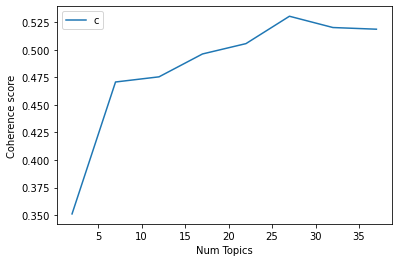

In [87]:
# Show graph

plt.plot(best_coherence_cases['num_topics'], best_coherence_cases['Coherence Score'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [89]:
# Show Topics

pprint(model.show_topics(formatted=True))

[(25,
  '0.025*"political" + 0.022*"amendment" + 0.020*"interest" + 0.018*"speech" + '
  '0.017*"corporate" + 0.015*"business" + 0.015*"corporation" + '
  '0.014*"corporations" + 0.014*"court" + 0.012*"public"'),
 (22,
  '0.052*"grant" + 0.030*"bridge" + 0.026*"ferry" + 0.021*"public" + '
  '0.018*"franchise" + 0.014*"charter" + 0.013*"plaintiffs" + 0.012*"toll" + '
  '0.012*"legislature" + 0.011*"property"'),
 (10,
  '0.074*"state" + 0.030*"court" + 0.019*"law" + 0.015*"make" + '
  '0.014*"question" + 0.012*"time" + 0.010*"unite" + 0.008*"limit" + '
  '0.008*"exercise" + 0.008*"can_not"'),
 (26,
  '0.034*"president" + 0.027*"unite" + 0.021*"commission" + 0.020*"court" + '
  '0.019*"executive" + 0.015*"officer" + 0.013*"district" + 0.012*"evidence" + '
  '0.011*"office" + 0.011*"order"'),
 (19,
  '0.031*"congress" + 0.029*"state" + 0.028*"federal" + 0.022*"tax" + '
  '0.017*"power" + 0.014*"medicaid" + 0.014*"act" + 0.012*"commerce" + '
  '0.011*"provision" + 0.011*"fund"'),
 (9,
  '0.

In [90]:
# Wrappped LDAMallet into LDA to plot with pyLDAvis

modely = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)

In [91]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(modely, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.000520 -0.000112       1        1  19.852782
9      0.000175 -0.000486       2        1  17.886884
0      0.000464  0.000221       3        1   6.176274
4     -0.000276 -0.000133       4        1   6.013890
3      0.000282  0.000035       5        1   4.576102
17    -0.000295 -0.000349       6        1   4.563611
22     0.000272 -0.000061       7        1   4.477605
19    -0.000272 -0.000189       8        1   2.865795
2      0.000430 -0.000535       9        1   2.777374
1     -0.000451 -0.000096      10        1   2.640019
7      0.000122  0.000353      11        1   2.379661
25     0.000031 -0.000139      12        1   2.268010
18    -0.000506 -0.000640      13        1   2.139174
12    -0.000159  0.000483      14        1   2.053737
16    -0.000337  0.000202      15        1   1.896872
21     0.000510 -0.000463      16        1   1.877785
20    -0.000224 -0.000285      17        1   1.696021
13     0.000159  0.000182      18        1   1.689141
5     -0.000094  0.000306      19        1   1.684153
14    -0.000166  0.000097      20        1   1.614077
8     -0.000203  0.000388      21        1   1.517336
23    -0.000227  0.000503      22        1   1.500410
24    -0.000170  0.000418      23        1   1.400049
11     0.000341  0.000321      24        1   1.336864
6      0.000406  0.000299      25        1   1.131624
26     0.000650 -0.000086      26        1   1.125284
15     0.000059 -0.000233      27        1   0.859465, topic_info=                       Term       Freq      Total Category  logprob  loglift
20729              housesee  11.000000  11.000000  Default  30.0000  30.0000
3688            monopolyone  10.000000  10.000000  Default  29.0000  29.0000
12273  bakery_confectionery  10.000000  10.000000  Default  28.0000  28.0000
18088                tollmo  10.000000  10.000000  Default  27.0000  27.0000
20758                  jack  11.000000  11.000000  Default  26.0000  26.0000
...                     ...        ...        ...      ...      ...      ...
27910              epperson   0.119184  11.056367  Topic27 -10.5440   0.2265
18088                tollmo   0.118966  10.904842  Topic27 -10.5458   0.2385
1796            causeenough   0.118547  10.583969  Topic27 -10.5493   0.2648
43257        interestabrams   0.118377  10.564229  Topic27 -10.5508   0.2653
41972   ratificationoctober   0.118387  10.912375  Topic27 -10.5507   0.2329

[1248 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
36411      1  0.190062   aasecond
36411      2  0.190062   aasecond
36411      3  0.095031   aasecond
36411      4  0.095031   aasecond
36411      6  0.095031   aasecond
...      ...       ...        ...
30729      6  0.094822      zeiss
46655      1  0.206219  zeroquite
46655      2  0.103109  zeroquite
46655      3  0.103109  zeroquite
46655      4  0.103109  zeroquite

[5733 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 10, 1, 5, 4, 18, 23, 20, 3, 2, 8, 26, 19, 13, 17, 22, 21, 14, 6, 15, 9, 24, 25, 12, 7, 27, 16])